In [2]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_tree
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
credit_df=pd.read_csv('../Resources/credit_record.csv', index_col="ID")
application_df=pd.read_csv('../Resources/application_record.csv', index_col="ID")

In [4]:
application_df.head()

,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,,
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [7]:
credit_df.head()

,MONTHS_BALANCE,STATUS
ID,,
5001711,0,X
5001711,-1,0
5001711,-2,0
5001711,-3,0
5001712,0,C
5001712,-1,C
5001712,-2,C
5001712,-3,C
5001712,-4,C


In [8]:
# One-Hot Encoding and Grouping
credit_grouped = pd.get_dummies(credit_df, columns=['STATUS']).groupby('ID').sum()

# Counting the Number of Months
credit_grouped['number_of_months'] = credit_df.groupby('ID')['MONTHS_BALANCE'].count()

# Renaming Columns for Clarity
status_mapping = {
    'STATUS_0': 'pastdue_1_29',
    'STATUS_1': 'pastdue_30_59',
    'STATUS_2': 'pastdue_60_89',
    'STATUS_3': 'pastdue_90_119',
    'STATUS_4': 'pastdue_120_149',
    'STATUS_5': 'pastdue_over_150',
    'STATUS_C': 'paid_off',
    'STATUS_X': 'no_loan'
}
credit_grouped.rename(columns=status_mapping, inplace=True)
credit_grouped.drop(columns=['MONTHS_BALANCE'], inplace=True)
credit_grouped.head()


,pastdue_1_29,pastdue_30_59,pastdue_60_89,pastdue_90_119,pastdue_120_149,pastdue_over_150,paid_off,no_loan,number_of_months
ID,,,,,,,,,
5001711,3,0,0,0,0,0,0,1,4
5001712,10,0,0,0,0,0,9,0,19
5001713,0,0,0,0,0,0,0,22,22
5001714,0,0,0,0,0,0,0,15,15
5001715,0,0,0,0,0,0,0,60,60


In [9]:
credit_grouped['customer_status'] = credit_grouped['pastdue_30_59'].apply(lambda x: 1 if x > 0 else 0)

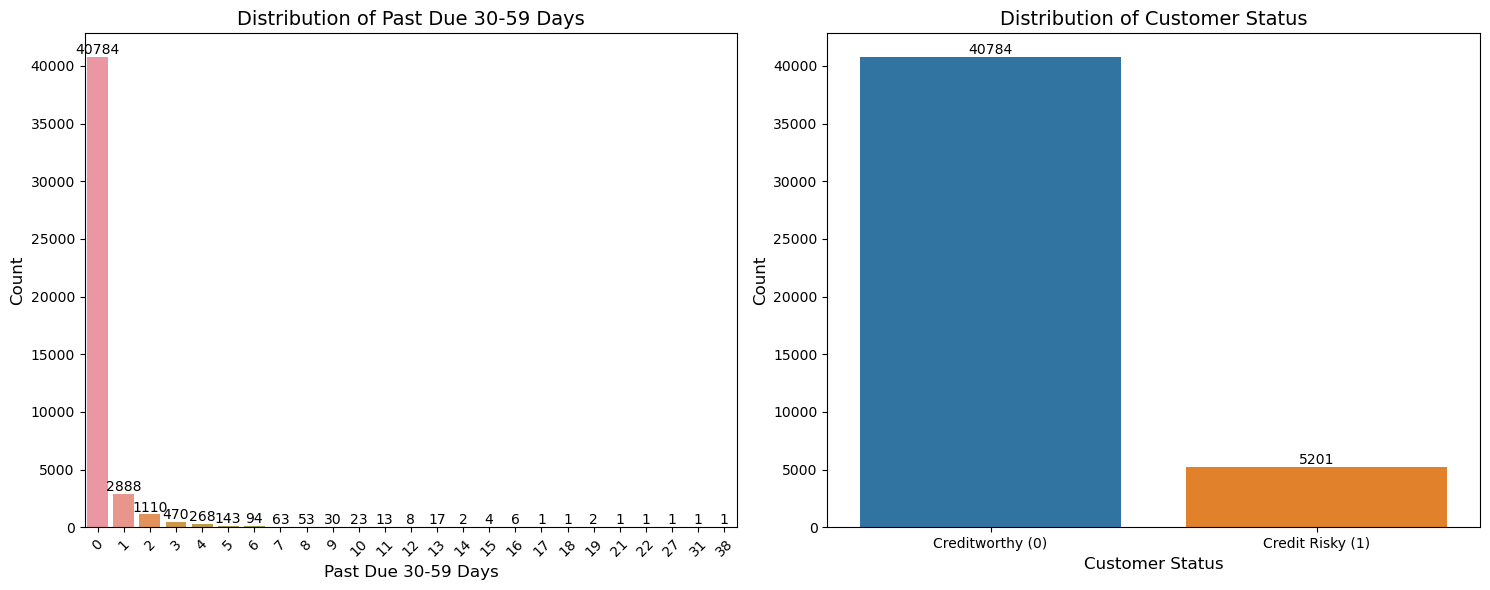

In [10]:
plt.figure(figsize=(15, 6))

# Function to add data labels
def add_data_labels(ax):
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Subplot for 'pastdue_30_59'
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='pastdue_30_59', data=credit_grouped)
plt.title('Distribution of Past Due 30-59 Days', fontsize=14)
plt.xlabel('Past Due 30-59 Days', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
add_data_labels(ax1)

# Subplot for 'customer_status'
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='customer_status', data=credit_grouped)
plt.title('Distribution of Customer Status', fontsize=14)
plt.xlabel('Customer Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Creditworthy (0)', 'Credit Risky (1)'], fontsize=10)
plt.yticks(fontsize=10)
add_data_labels(ax2)

plt.tight_layout()
plt.show()



In [11]:
credit_grouped['customer_status'] = credit_grouped['pastdue_60_89'].apply(lambda x: 1 if x > 0 else 0)

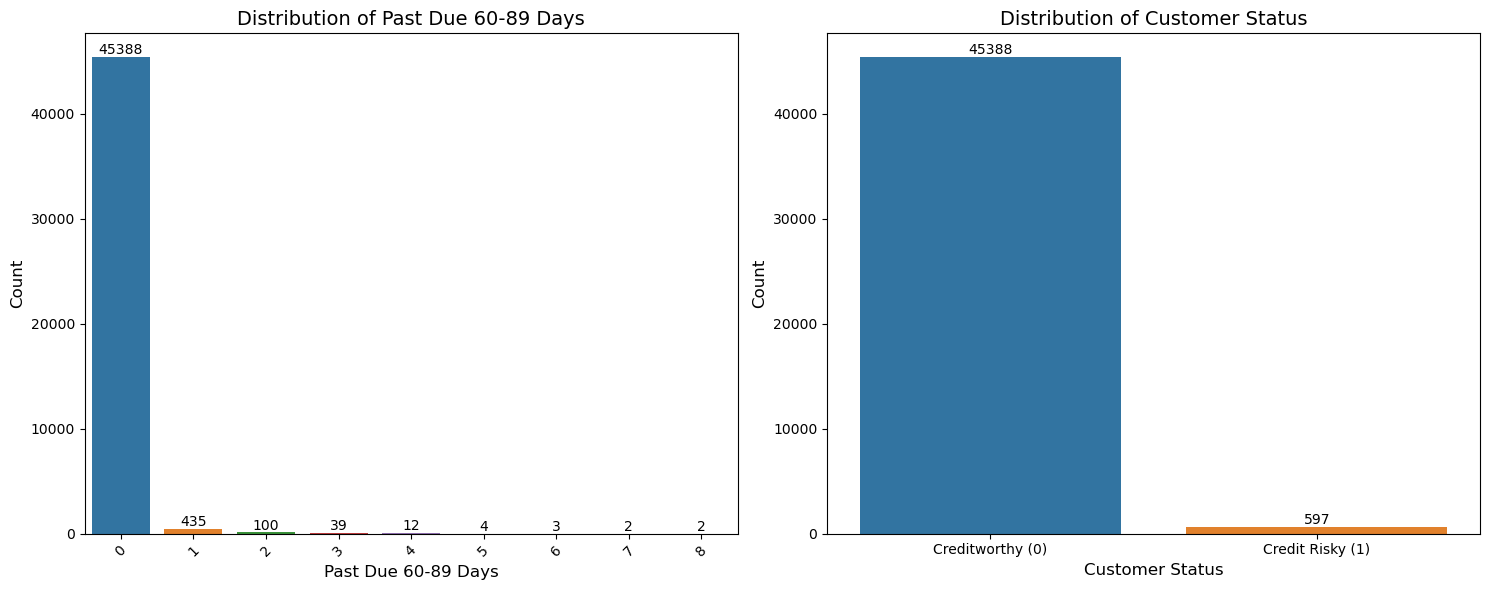

In [12]:
plt.figure(figsize=(15, 6))

# Subplot for 'pastdue_60_89'
plt.subplot(1, 2, 1)
ax1 = sns.countplot(x='pastdue_60_89', data=credit_grouped)
plt.title('Distribution of Past Due 60-89 Days', fontsize=14)
plt.xlabel('Past Due 60-89 Days', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
add_data_labels(ax1)

# Subplot for 'customer_status'
plt.subplot(1, 2, 2)
ax2 = sns.countplot(x='customer_status', data=credit_grouped)
plt.title('Distribution of Customer Status', fontsize=14)
plt.xlabel('Customer Status', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1], ['Creditworthy (0)', 'Credit Risky (1)'], fontsize=10)
plt.yticks(fontsize=10)
add_data_labels(ax2)

plt.tight_layout()
plt.show()

In [13]:
#Right now our 0-1 tagging is using 60 day past due customers. If we wanna change it back to 30 days past due, we simply run this code again.
#credit_grouped['customer_status'] = credit_grouped['pastdue_30_59'].apply(lambda x: 1 if x > 0 else 0)

In [14]:
merged_df = pd.merge(credit_grouped[["customer_status"]], application_df, how='inner', left_index=True, right_index=True)

In [15]:
merged_df.head()

,customer_status,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
ID,,,,,,,,,,,,,,,,,,
5008804,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
5008805,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
5008806,0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
5008808,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
5008809,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [16]:
#Converting "DAYS_BIRTH" column to Age
merged_df['AGE'] = round(-merged_df["DAYS_BIRTH"]/365.25)
merged_df.drop(columns=['DAYS_BIRTH'], inplace=True)
merged_df['AGE'].unique()

array([33., 59., 52., 62., 46., 49., 29., 51., 27., 30., 35., 32., 56.,
       43., 44., 34., 55., 47., 42., 37., 28., 61., 57., 45., 54., 40.,
       39., 48., 24., 21., 36., 26., 50., 63., 58., 41., 60., 31., 38.,
       53., 22., 64., 23., 25., 65., 67., 66., 69., 68.])

In [17]:
#Converting "DAYS_EMPLOYED" column to Years of Employment
merged_df['YEARS_EMPLOYED'] = round(-merged_df["DAYS_EMPLOYED"]/365.25)
merged_df.drop(columns=['DAYS_EMPLOYED'], inplace=True)
merged_df['YEARS_EMPLOYED'].unique()

array([   12.,     3.,     8., -1000.,     2.,     4.,     6.,     9.,
          19.,    15.,     5.,    13.,     7.,    17.,    30.,    16.,
          11.,     1.,    10.,    24.,    14.,    25.,     0.,    20.,
          27.,    18.,    21.,    23.,    22.,    28.,    39.,    32.,
          33.,    37.,    26.,    38.,    31.,    29.,    35.,    34.,
          41.,    40.,    36.,    42.,    43.])

In [18]:
#For years employed, negative values mean applicant doesn't work, so we convert negative values to 0 as well
merged_df.loc[(merged_df['YEARS_EMPLOYED'] < 0), 'YEARS_EMPLOYED'] = 0

In [19]:
merged_df.head()

,customer_status,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
ID,,,,,,,,,,,,,,,,,,
5008804,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,33.0,12.0
5008805,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,NaN,2.0,33.0,12.0
5008806,0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,1,0,0,0,Security staff,2.0,59.0,3.0
5008808,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52.0,8.0
5008809,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,1,0,1,1,Sales staff,1.0,52.0,8.0


In [20]:
for column in merged_df.columns:
    value_counts_result = merged_df[column].value_counts()
    print(f"\nValue counts for column '{column}':\n{value_counts_result}")



Value counts for column 'customer_status':
customer_status
0    35902
1      555
Name: count, dtype: int64

Value counts for column 'CODE_GENDER':
CODE_GENDER
F    24430
M    12027
Name: count, dtype: int64

Value counts for column 'FLAG_OWN_CAR':
FLAG_OWN_CAR
N    22614
Y    13843
Name: count, dtype: int64

Value counts for column 'FLAG_OWN_REALTY':
FLAG_OWN_REALTY
Y    24506
N    11951
Name: count, dtype: int64

Value counts for column 'CNT_CHILDREN':
CNT_CHILDREN
0     25201
1      7492
2      3256
3       419
4        63
5        20
14        3
7         2
19        1
Name: count, dtype: int64

Value counts for column 'AMT_INCOME_TOTAL':
AMT_INCOME_TOTAL
135000.0    4309
180000.0    3097
157500.0    3089
112500.0    2956
225000.0    2926
            ... 
147150.0       1
177750.0       1
134995.5       1
31950.0        1
74061.0        1
Name: count, Length: 265, dtype: int64

Value counts for column 'NAME_INCOME_TYPE':
NAME_INCOME_TYPE
Working                 18819
Commercial ass

In [21]:
#Dropping what is not necessary. "FLAG_MOBIL", "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL" is what info customers left when applying. It's not gonna be necessary or decisive on our model.
merged_df.drop(columns=["FLAG_MOBIL", "FLAG_WORK_PHONE", "FLAG_PHONE", "FLAG_EMAIL"], inplace=True)

In [22]:
merged_df.isnull().sum()

customer_status            0
CODE_GENDER                0
FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
OCCUPATION_TYPE        11323
CNT_FAM_MEMBERS            0
AGE                        0
YEARS_EMPLOYED             0
dtype: int64

In [23]:
merged_df.dtypes

customer_status          int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
AGE                    float64
YEARS_EMPLOYED         float64
dtype: object

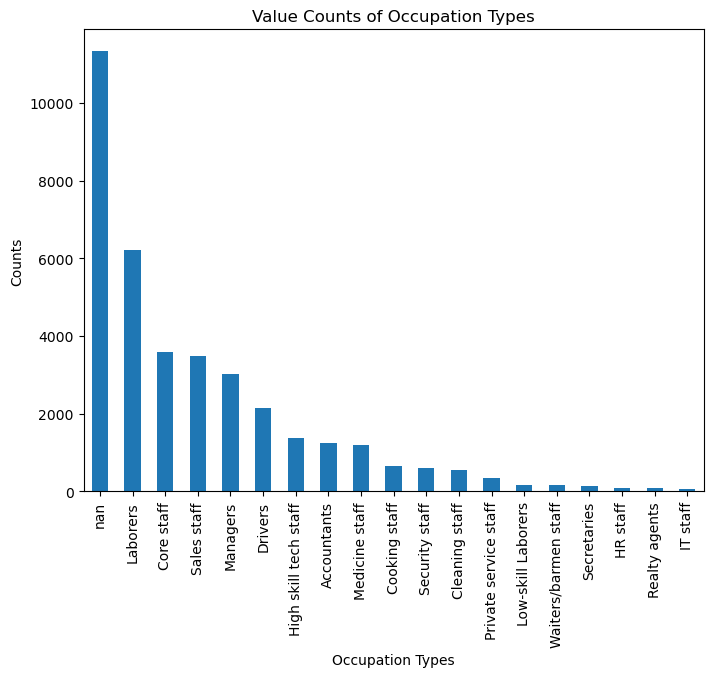

In [24]:
ot_value_counts = merged_df['OCCUPATION_TYPE'].value_counts(dropna=False)
plt.figure(figsize=(8, 6))
ot_value_counts.plot(kind='bar')
plt.title('Value Counts of Occupation Types')
plt.xlabel('Occupation Types')
plt.ylabel('Counts')
plt.xticks(rotation=90)
plt.show()

In [25]:
# We're going to address the issue of "OCCUPATION_TYPE" having so many NaN values by training a machine learning model and filling the missing values with it.
# Separate the rows with and without NaN values in the 'OCCUPATION_TYPE' column
df_nan = merged_df[merged_df['OCCUPATION_TYPE'].isna()]
df_not_nan = merged_df.dropna(subset=['OCCUPATION_TYPE'])

# Encode categorical columns
label_encoder = LabelEncoder()
encoded_labels = {}
for column in df_not_nan.select_dtypes(include=['object']).columns:
    df_not_nan[column] = label_encoder.fit_transform(df_not_nan[column])
    encoded_labels[column] = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

# Identify features (X) and target variable (y)
X = df_not_nan.drop(['OCCUPATION_TYPE'], axis=1)
y = label_encoder.fit_transform(df_not_nan['OCCUPATION_TYPE'])  # Encode target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

/var/folders/9z/mjxxydhd64v1_mckv3vlz0h00000gn/T/ipykernel_52553/2807280212.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_nan[column] = label_encoder.fit_transform(df_not_nan[column])
/var/folders/9z/mjxxydhd64v1_mckv3vlz0h00000gn/T/ipykernel_52553/2807280212.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_nan[column] = label_encoder.fit_transform(df_not_nan[column])
/var/folders/9z/mjxxydhd64v1_mckv3vlz0h00000gn/T/ipykernel_52553/2807280212.py:10: SettingWithCopyWarning: 
A value 

In [26]:
# ### Tuning RandomForest for classifying Occupation Type

# # Define the model
# rf_ot = RandomForestClassifier(random_state=42)

# # Define the parameter grid
# param_grid_rf_ot = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# # Create GridSearchCV
# grid_search_rf_ot = GridSearchCV(estimator=rf_ot, param_grid=param_grid_rf_ot, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the Occupation Type training data
# grid_search_rf_ot.fit(X_train, y_train)

# # Print the best parameters
# print("Best parameters for undersampled data (RandomForest):", grid_search_rf_ot.best_params_)

In [27]:
# Create a Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, max_depth= None, max_features= 'auto', min_samples_leaf= 1, min_samples_split= 2, n_estimators= 300)

# Train the model
rf_classifier.fit(X_train, y_train)

# Evaluate the model on the test set
y_true = y_test  # True labels from the test set
y_pred = rf_classifier.predict(X_test)  # Predicted labels on the test set


# Generate and display classification report
report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
print("Classification Report:")
display(report_df)

/Users/kobe/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Classification Report:


,precision,recall,f1-score,support
0,0.950943,0.933333,0.942056,270.000000
1,0.947826,0.923729,0.935622,118.000000
2,0.950413,0.845588,0.894942,136.000000
3,0.924451,0.914402,0.919399,736.000000
4,0.890625,0.925754,0.907850,431.000000
5,0.857143,0.923077,0.888889,13.000000
6,0.941818,0.883959,0.911972,293.000000
7,1.000000,0.900000,0.947368,10.000000
8,0.917402,0.938474,0.927818,1219.000000
9,1.000000,0.939394,0.968750,33.000000


In [28]:
# Identify rows with NaN values in the target variable
X_nan = df_nan.drop(['OCCUPATION_TYPE'], axis=1)

# Encode categorical columns in the NaN rows
for column in X_nan.select_dtypes(include=['object']).columns:
    # Check if label encoder has seen the label before transforming
    X_nan[column] = X_nan[column].map(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)

# Predict the missing values
predicted_occupations = rf_classifier.predict(X_nan)

# Reverse label encoding using the mapping dictionary
predicted_occupations_original = [encoded_labels['OCCUPATION_TYPE'].get(label, label) for label in predicted_occupations]

predicted_occupations_original = [key for label in predicted_occupations for key, value in encoded_labels['OCCUPATION_TYPE'].items() if value == label]

# Fill NaN values with predicted values
merged_df.loc[merged_df['OCCUPATION_TYPE'].isna(), 'OCCUPATION_TYPE'] = predicted_occupations_original

/var/folders/9z/mjxxydhd64v1_mckv3vlz0h00000gn/T/ipykernel_52553/1842177641.py:7: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  X_nan[column] = X_nan[column].map(lambda x: label_encoder.transform([x])[0] if x in label_encoder.classes_ else -1)


In [29]:
merged_df.head()

,customer_status,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED
ID,,,,,,,,,,,,,,
5008804,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,Managers,2.0,33.0,12.0
5008805,0,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,Managers,2.0,33.0,12.0
5008806,0,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,Security staff,2.0,59.0,3.0
5008808,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,52.0,8.0
5008809,0,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff,1.0,52.0,8.0


In [30]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

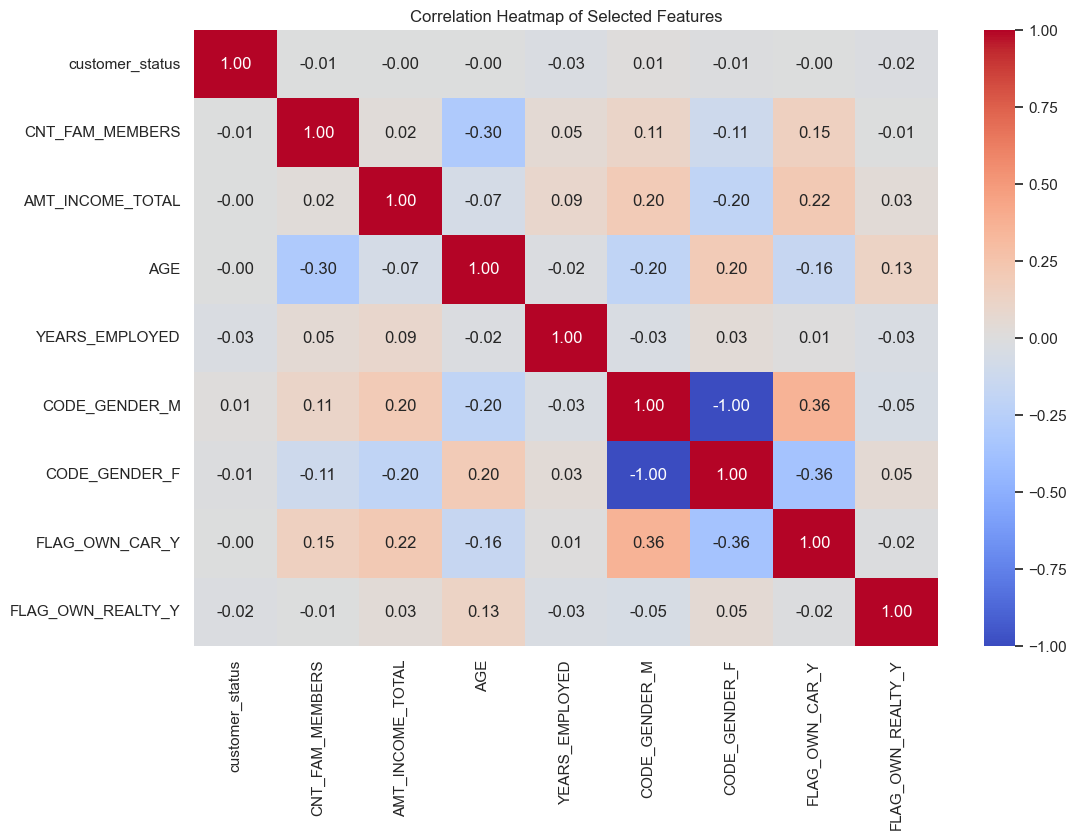

In [31]:
# One-hot encoding for the selected categorical variables
merged_df_subset = pd.get_dummies(merged_df, columns=['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY'])

# Selecting a subset of key features for correlation analysis
selected_features = ['customer_status', 'CNT_FAM_MEMBERS', 'AMT_INCOME_TOTAL', 
                     'AGE', 'YEARS_EMPLOYED', 
                     'CODE_GENDER_M', 'CODE_GENDER_F', 'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_Y']

# Keeping only the selected features
merged_df_subset = merged_df_subset[selected_features]

# Calculating the correlation matrix for the subset
corr_matrix_subset = merged_df_subset.corr()

# Plotting the heatmap for the subset
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_subset, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Heatmap of Selected Features')
plt.show()

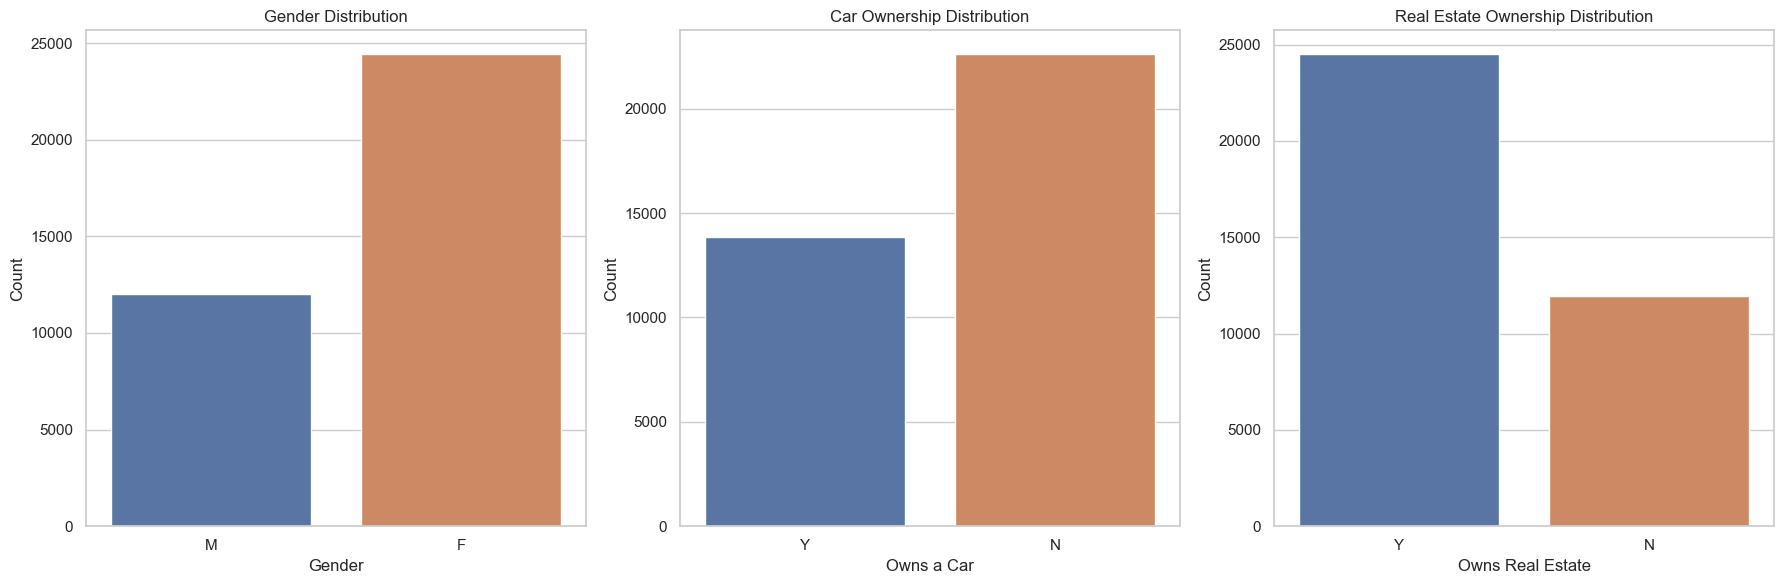

In [32]:
# Plotting distributions of some categorical variables
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Gender distribution
sns.countplot(x='CODE_GENDER', data=merged_df, ax=axes[0])
axes[0].set_title('Gender Distribution')
axes[0].set_xlabel('Gender')
axes[0].set_ylabel('Count')

# Car ownership distribution
sns.countplot(x='FLAG_OWN_CAR', data=merged_df, ax=axes[1])
axes[1].set_title('Car Ownership Distribution')
axes[1].set_xlabel('Owns a Car')
axes[1].set_ylabel('Count')

# Real estate ownership distribution
sns.countplot(x='FLAG_OWN_REALTY', data=merged_df, ax=axes[2])
axes[2].set_title('Real Estate Ownership Distribution')
axes[2].set_xlabel('Owns Real Estate')
axes[2].set_ylabel('Count')

plt.tight_layout()
plt.show()

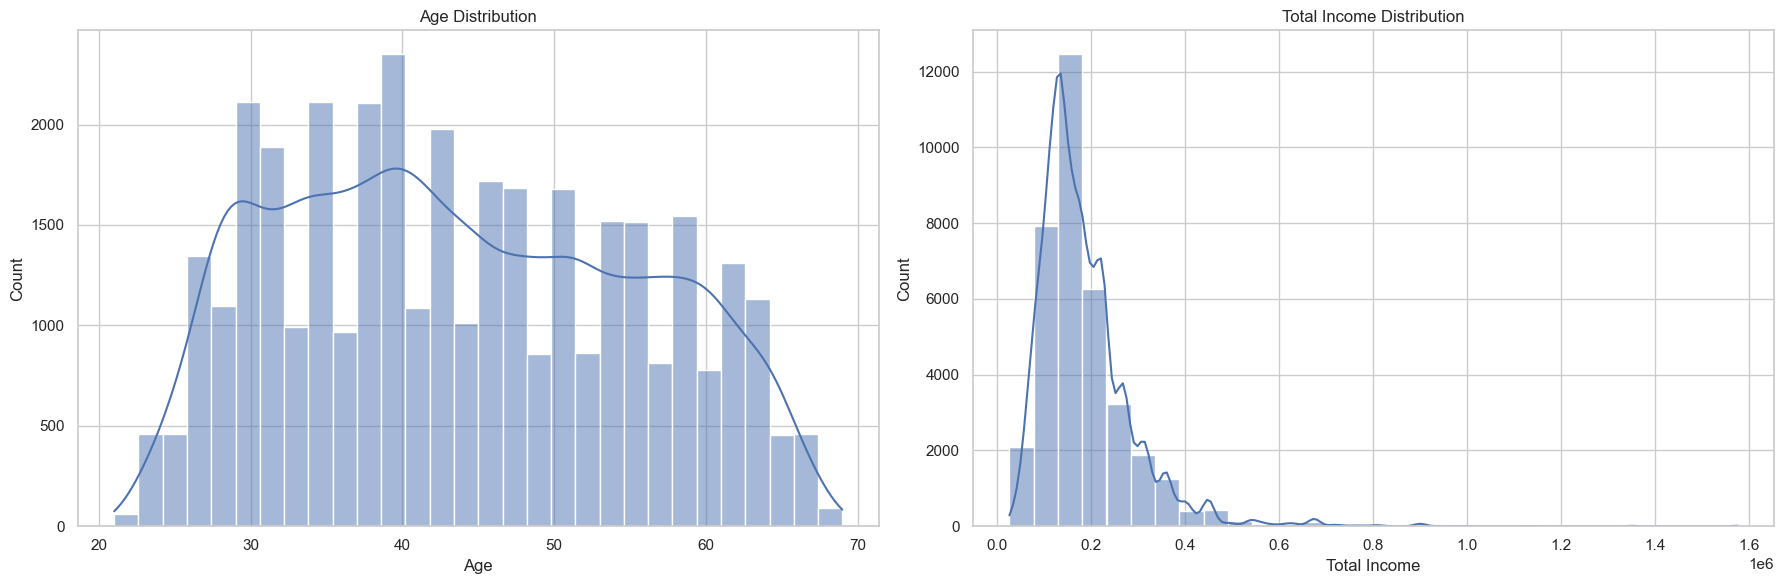

In [33]:
# Plotting distributions of some numerical variables
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Age distribution
sns.histplot(merged_df['AGE'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Age Distribution')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Count')

# Total Income distribution
sns.histplot(merged_df['AMT_INCOME_TOTAL'], bins=30, kde=True, ax=axes[1])
axes[1].set_title('Total Income Distribution')
axes[1].set_xlabel('Total Income')
axes[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [34]:
# # We will bin the Income Amount to 4 quartiles.
# income_quartiles = merged_df['AMT_INCOME_TOTAL'].quantile([0.25, 0.5, 0.75])
# bins_income = [0, income_quartiles[0.25], income_quartiles[0.5], income_quartiles[0.75], np.inf]
# labels_income = ['Up to 121,500', '121,500-157,500', '157,000-225,000', '225,000+']
# merged_df['INCOME_BINNED'] = pd.cut(merged_df['AMT_INCOME_TOTAL'], bins=bins_income, labels=labels_income, right=False)


In [35]:
# # Binning the years employed
# bins_years_employed = [0, 5, 10, 15, 20, np.inf]
# labels_years_employed = ['0-5 years', '6-10 years', '11-15 years', '16-20 years', '21+ years']
# merged_df['YEARS_EMPLOYED_BINNED'] = pd.cut(merged_df['YEARS_EMPLOYED'], bins=bins_years_employed, labels=labels_years_employed, right=False)

In [36]:
# plt.figure(figsize=(12, 6))
# sns.countplot(x='YEARS_EMPLOYED_BINNED', hue='INCOME_BINNED', data=merged_df)
# plt.title('Income Distribution across Years of Employment')
# plt.xlabel('Years of Employment')
# plt.ylabel('Count')
# plt.legend(title='Income Group')
# plt.show()

In [37]:
# # Binning the age
# bins_age = [21, 36, 51, 66, np.inf]
# labels_age = ['21-35 years', '36-50 years', '51-65 years', '66+ years']
# merged_df['AGE_BINNED'] = pd.cut(merged_df['AGE'], bins=bins_age, labels=labels_age, right=False)

In [38]:
# plt.figure(figsize=(12, 6))
# sns.countplot(x='AGE_BINNED', hue='INCOME_BINNED', data=merged_df)
# plt.title('Income Distribution across Different Age Groups')
# plt.xlabel('Age Group')
# plt.ylabel('Count')
# plt.legend(title='Income Group')
# plt.show()

In [39]:
#merged_df.drop(columns=['AGE', 'YEARS_EMPLOYED', 'AMT_INCOME_TOTAL'], inplace=True)

In [40]:
# # Converting binned columns to string type
# merged_df['AGE_BINNED'] = merged_df['AGE_BINNED'].astype(str)
# merged_df['INCOME_BINNED'] = merged_df['INCOME_BINNED'].astype(str)
# merged_df['YEARS_EMPLOYED_BINNED'] = merged_df['YEARS_EMPLOYED_BINNED'].astype(str)


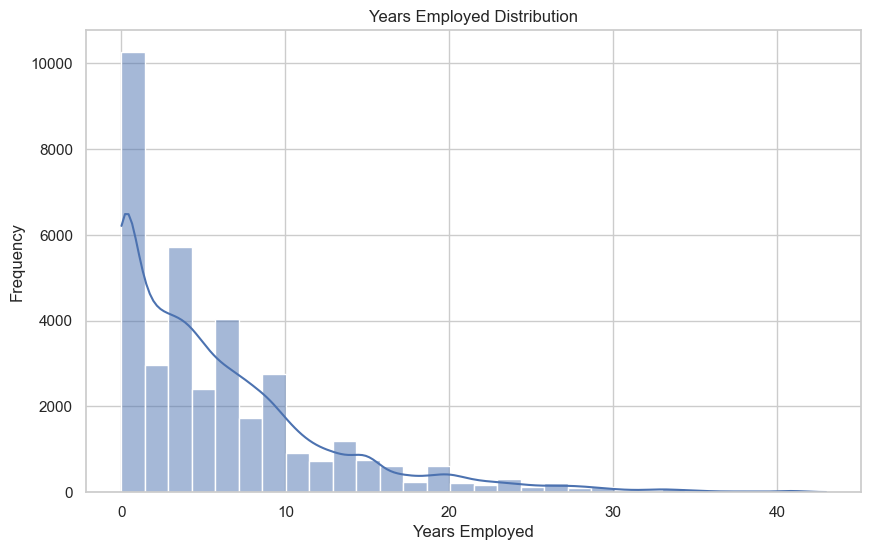

In [41]:
# Years Employed Distribution
plt.figure(figsize=(10, 6))
sns.histplot(merged_df['YEARS_EMPLOYED'], kde=True, bins=30)
plt.title('Years Employed Distribution')
plt.xlabel('Years Employed')
plt.ylabel('Frequency')
plt.show()


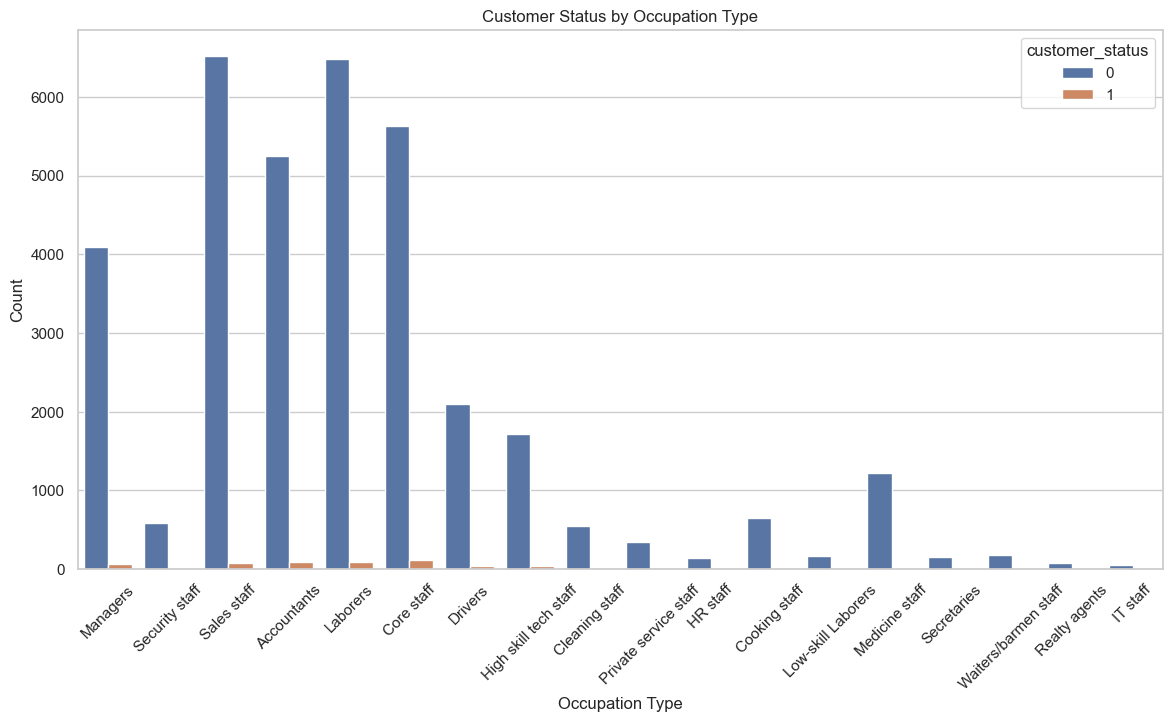

In [42]:
# Customer Status by Occupation Type
plt.figure(figsize=(14, 7))
sns.countplot(x='OCCUPATION_TYPE', hue='customer_status', data=merged_df)
plt.title('Customer Status by Occupation Type')
plt.xlabel('Occupation Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


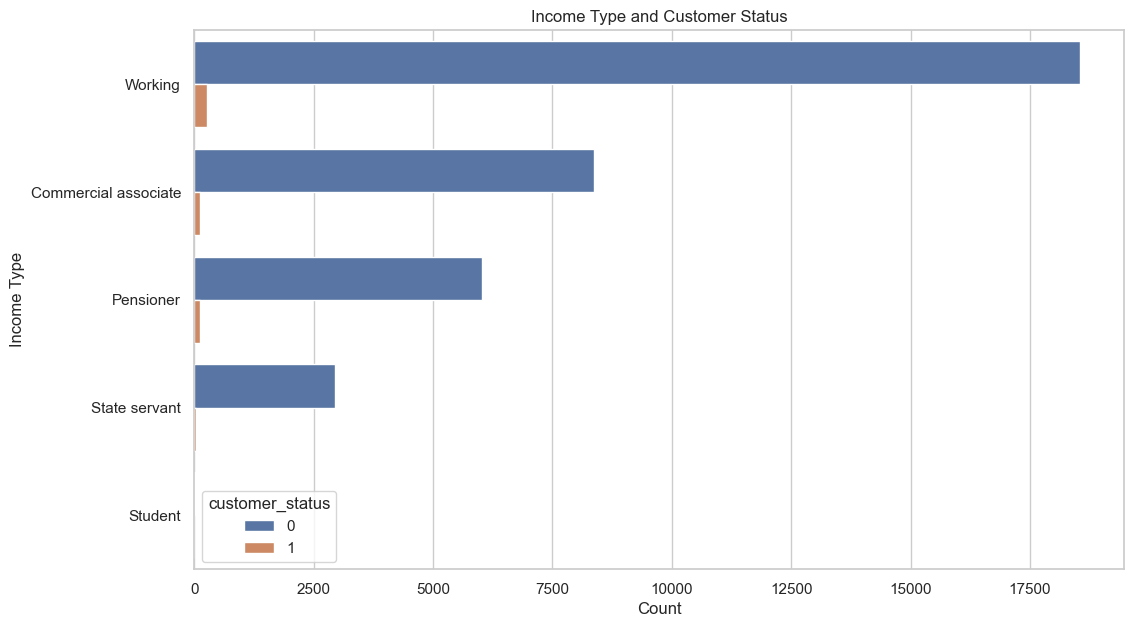

In [43]:
# Income Type and Customer Status
plt.figure(figsize=(12, 7))
sns.countplot(y='NAME_INCOME_TYPE', hue='customer_status', data=merged_df)
plt.title('Income Type and Customer Status')
plt.xlabel('Count')
plt.ylabel('Income Type')
plt.show()


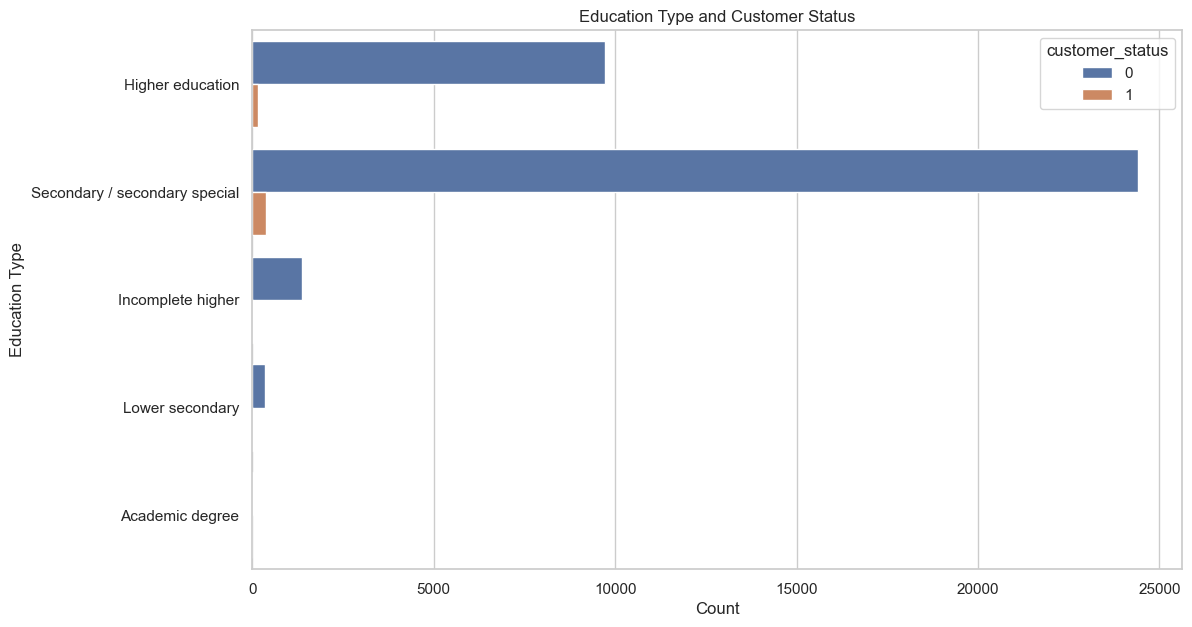

In [44]:
# Education Type and Customer Status
plt.figure(figsize=(12, 7))
sns.countplot(y='NAME_EDUCATION_TYPE', hue='customer_status', data=merged_df)
plt.title('Education Type and Customer Status')
plt.xlabel('Count')
plt.ylabel('Education Type')
plt.show()


In [45]:
# Children Count column is a subset of Family Members Count column, we will drop one and simplify the other one to reduce the noise.
merged_df.drop(columns=['CNT_CHILDREN'], inplace=True)
merged_df['CNT_FAM_MEMBERS'] = merged_df['CNT_FAM_MEMBERS'].apply(lambda x: x if x < 4 else '4 or more')

In [ ]:
# Selecting categorical columns for encoding and numerical columns for scaling
categorical_cols = merged_df.select_dtypes(include=['object', 'category']).columns
numerical_cols = merged_df.select_dtypes(include=['int64', 'float64']).drop('customer_status', axis=1).columns

# Apply the ColumnTransformer
ct = ColumnTransformer([
    ('one_hot_encoder', OneHotEncoder(sparse=False), categorical_cols),
    ('scaler', StandardScaler(), numerical_cols)
], remainder='passthrough')

In [46]:
# Selecting categorical columns for encoding and numerical columns for scaling
categorical_cols = merged_df.select_dtypes(include=['object', 'category']).columns
numerical_cols = merged_df.select_dtypes(include=['int64', 'float64']).drop('customer_status', axis=1).columns

# Before applying the ColumnTransformer we make sure all categorical data are strings
for col in categorical_cols:
    merged_df[col] = merged_df[col].astype(str)

# Apply the ColumnTransformer
ct = ColumnTransformer([
    ('one_hot_encoder', OneHotEncoder(sparse=False), categorical_cols),
    ('scaler', StandardScaler(), numerical_cols)
], remainder='passthrough')

# Applying ColumnTransformer to feature set
X = ct.fit_transform(merged_df.drop('customer_status', axis=1))

# Target variable
y = merged_df['customer_status']

# Splitting dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

/Users/kobe/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [47]:
# Applying SMOTE to training set
sm = SMOTE(random_state=42)
X_train_smote, y_train_smote = sm.fit_resample(X_train, y_train)

In [49]:
# Apply undersampling to the training data
rus = RandomUnderSampler(random_state=42)
X_train_under, y_train_under = rus.fit_resample(X_train, y_train)

In [50]:
# ### Tuning Logistic Regression for SMOTE
# # Define the model
# lr_smote = LogisticRegression(random_state=42)

# # # Define the parameter grid
# param_grid_lr_smote = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga'],
#     'max_iter': [50, 100, 300]
# }

# # Create GridSearchCV
# grid_search_lr_smote = GridSearchCV(estimator=lr_smote, param_grid=param_grid_lr_smote, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the SMOTE-enhanced training data
# grid_search_lr_smote.fit(X_train_smote, y_train_smote)

# # Print the best parameters
# print("Best parameters for SMOTE data (Logistic Regression):", grid_search_lr_smote.best_params_)

In [51]:
# Create the model
lr_smote = LogisticRegression(random_state=42, C= 0.1, penalty= 'l1', solver='saga')

# Train the model on SMOTE data
lr_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
lr_predictions_smote = lr_smote.predict(X_test)

# Generate and display the classification report 
report_lr_smote = classification_report(y_test, lr_predictions_smote, output_dict=True)
report_lr_smote_df = pd.DataFrame(report_lr_smote).transpose()
print("Classification Report:")
display(report_lr_smote_df)

Classification Report:


,precision,recall,f1-score,support
0,0.990260,0.554727,0.711105,8981.000000
1,0.020813,0.634328,0.040303,134.000000
accuracy,0.555897,0.555897,0.555897,0.555897
macro avg,0.505537,0.594528,0.375704,9115.000000
weighted avg,0.976008,0.555897,0.701243,9115.000000


In [52]:
# ### Tuning Logistic Regression for Undersampled
# # Define the model
# lr_under = LogisticRegression(random_state=42)

# # Define the parameter grid
# param_grid_lr_under = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'penalty': ['l1', 'l2', 'elasticnet', 'none'],
#     'solver': ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
# }

# # Create GridSearchCV
# grid_search_lr_under = GridSearchCV(estimator=lr_under, param_grid=param_grid_lr_under, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the undersampled training data
# grid_search_lr_under.fit(X_train_under, y_train_under)

# # Print the best parameters
# print("Best parameters for undersampled data (Logistic Regression):", grid_search_lr_under.best_params_)

In [53]:
# Create the model
lr_under = LogisticRegression(random_state=42, C= 1, penalty= 'l1', solver='saga')

# Train the model on Undersampled data
lr_under.fit(X_train_under, y_train_under)

# Predict on the test set
lr_predictions_under = lr_under.predict(X_test)

# Generate and display the Classification Report
report_lr_under = classification_report(y_test, lr_predictions_under, output_dict=True)
report_lr_under_df = pd.DataFrame(report_lr_under).transpose()
print("Classification Report:")
display(report_lr_under_df)

Classification Report:


/Users/kobe/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,precision,recall,f1-score,support
0,0.990169,0.527113,0.687981,8981.000000
1,0.020074,0.649254,0.038944,134.000000
accuracy,0.528908,0.528908,0.528908,0.528908
macro avg,0.505122,0.588183,0.363462,9115.000000
weighted avg,0.975908,0.528908,0.678440,9115.000000


In [54]:
# ### Tuning RandomForest for SMOTE

# # Define the model
# rf_smote = RandomForestClassifier(random_state=42)

# # Define the parameter grid
# param_grid_rf_smote = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# # Create GridSearchCV
# grid_search_rf_smote = GridSearchCV(estimator=rf_smote, param_grid=param_grid_rf_smote, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the SMOTE-enhanced training data
# grid_search_rf_smote.fit(X_train_smote, y_train_smote)

# # Print the best parameters
# print("Best parameters for SMOTE data (RandomForest):", grid_search_rf_smote.best_params_)

In [55]:
# Create the model
rf_smote = RandomForestClassifier(random_state=42, n_estimators=300, min_samples_split=5, min_samples_leaf=1, max_depth=None)

# Train the model on SMOTE data
rf_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
rf_predictions_smote = rf_smote.predict(X_test)

# Generate and display the classification report 
report_rf_smote = classification_report(y_test, rf_predictions_smote, output_dict=True)
report_rf_smote_df = pd.DataFrame(report_rf_smote).transpose()
print("Classification Report:")
display(report_rf_smote_df)


Classification Report:


,precision,recall,f1-score,support
0,0.989456,0.992651,0.991051,8981.000000
1,0.371429,0.291045,0.326360,134.000000
accuracy,0.982337,0.982337,0.982337,0.982337
macro avg,0.680442,0.641848,0.658705,9115.000000
weighted avg,0.980371,0.982337,0.981279,9115.000000


In [56]:
# ### Tuning RandomForest for Undersampled

# # Define the model
# rf_under = RandomForestClassifier(random_state=42)

# # Define the parameter grid
# param_grid_rf_under = {
#     'n_estimators': [100, 200, 300],
#     'max_depth': [10, 20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['auto', 'sqrt']
# }

# # Create GridSearchCV
# grid_search_rf_under = GridSearchCV(estimator=rf_under, param_grid=param_grid_rf_under, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the undersampled training data
# grid_search_rf_under.fit(X_train_under, y_train_under)

# # Print the best parameters
# print("Best parameters for undersampled data (RandomForest):", grid_search_rf_under.best_params_)

In [57]:
# Create the model
rf_under = RandomForestClassifier(random_state=42, max_depth= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100)

# Train the model on Undersampled data
rf_under.fit(X_train_under, y_train_under)

# Predict on the test set
rf_predictions_under = rf_under.predict(X_test)

# Generate and display the classification report 
report_rf_under = classification_report(y_test, rf_predictions_under, output_dict=True)
report_rf_under_df = pd.DataFrame(report_rf_under).transpose()
print("Classification Report:")
display(report_rf_under_df)

Classification Report:


,precision,recall,f1-score,support
0,0.993566,0.670638,0.800771,8981.000000
1,0.031117,0.708955,0.059617,134.000000
accuracy,0.671201,0.671201,0.671201,0.671201
macro avg,0.512342,0.689797,0.430194,9115.000000
weighted avg,0.979417,0.671201,0.789875,9115.000000


In [67]:
# ### Tuning XGBoost for SMOTE

# # Define the model
# xgb_smote = XGBClassifier(random_state=42)

# # Define the parameter grid
# param_grid_smote = {
#     'learning_rate': [0.01, 0.1, 0.2],
#     'max_depth': [5, 7, 10],
#     'n_estimators': [100, 200, 300],
#     'subsample': [0.7, 0.8, 0.9],
#     'colsample_bytree': [0.7, 0.8, 0.9]
# }

# # Create GridSearchCV
# grid_search_smote = GridSearchCV(estimator=xgb_smote, param_grid=param_grid_smote, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the SMOTE-enhanced training data
# grid_search_smote.fit(X_train_smote, y_train_smote)

# # Print the best parameters
# print("Best parameters for SMOTE data:", grid_search_smote.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.7; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.6s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, n_estimators=100, subsample=0.8; total time=   0.7s
[CV] END

/Users/kobe/anaconda3/envs/mlenv/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9; total time=   2.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9; total time=   2.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9; total time=   2.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.7; total time=   1.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9; total time=   2.4s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=100, subsample=0.7; total time=   1.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=7, n_estimators=300, subsample=0.9; total time=   2.5s
[CV] END colsample_bytree=0.7, learning_rate=0.1, max_depth=10, n_estimators=

In [59]:
# Create the model
xgb_smote = XGBClassifier(use_label_encoder=False, random_state=42, colsample_bytree= 0.7, learning_rate= 0.1, max_depth= 10, n_estimators= 300, subsample= 0.7)

# Train the model on SMOTE data
xgb_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
xgb_predictions_smote = xgb_smote.predict(X_test)

# Generate and display the classification report 
report_xgb_smote = classification_report(y_test, xgb_predictions_smote, output_dict=True)
report_xgb_smote_df = pd.DataFrame(report_xgb_smote).transpose()
print("Classification Report:")
display(report_xgb_smote_df)

Classification Report:


,precision,recall,f1-score,support
0,0.990209,0.990981,0.990595,8981.000000
1,0.362205,0.343284,0.352490,134.000000
accuracy,0.981459,0.981459,0.981459,0.981459
macro avg,0.676207,0.667132,0.671543,9115.000000
weighted avg,0.980977,0.981459,0.981214,9115.000000


In [66]:
# ### Tuning XGBoost for Undersampled

# # Define the model
# xgb_under = XGBClassifier(random_state=42)

# # Define the parameter grid
param_grid_under = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9]
}

# # Create GridSearchCV
# grid_search_under = GridSearchCV(estimator=xgb_under, param_grid=param_grid_under, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the undersampled training data
# grid_search_under.fit(X_train_under, y_train_under)

# # Print the best parameters
# print("Best parameters for undersampled data:", grid_search_under.best_params_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.7, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.8; total time=   0.0s
[CV] END

In [61]:
# Create the model
xgb_under = XGBClassifier(use_label_encoder=False, random_state=42, colsample_bytree= 0.7, learning_rate= 0.1, max_depth= 7, n_estimators= 100, subsample= 0.9)

# Train the model on Undersampled data
xgb_under.fit(X_train_under, y_train_under)

# Predict on the test set
xgb_predictions_under = xgb_under.predict(X_test)

# Generate and display the classification report 
report_xgb_under = classification_report(y_test, xgb_predictions_under, output_dict=True)
report_xgb_under_df = pd.DataFrame(report_xgb_under).transpose()
print("Classification Report:")
display(report_xgb_under_df)

Classification Report:


,precision,recall,f1-score,support
0,0.994111,0.639016,0.777959,8981.000000
1,0.029922,0.746269,0.057537,134.000000
accuracy,0.640592,0.640592,0.640592,0.640592
macro avg,0.512016,0.692642,0.417748,9115.000000
weighted avg,0.979936,0.640592,0.767368,9115.000000


In [ ]:
# ### Tuning MLP for SMOTE

# # Define the model
# mlp_smote = MLPClassifier(random_state=42)

# # Define the parameter grid
# param_grid_mlp_smote = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate_init': [0.001, 0.01],
#     'max_iter': [200, 300]
# }

# # Create GridSearchCV
# grid_search_mlp_smote = GridSearchCV(estimator=mlp_smote, param_grid=param_grid_mlp_smote, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the SMOTE-enhanced training data
# grid_search_mlp_smote.fit(X_train_smote, y_train_smote)

# # Print the best parameters
# print("Best parameters for SMOTE data (MLPClassifier):", grid_search_mlp_smote.best_params_)

In [63]:
# Create the model
nn_smote = MLPClassifier(random_state=42, alpha=0.0001, activation='tanh', solver='adam', hidden_layer_sizes= (100,), learning_rate_init= 0.001, max_iter= 300)

# Train the model on SMOTE data
nn_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
nn_predictions_smote = nn_smote.predict(X_test)

# Generate and display the classification report 
report_nn_smote = classification_report(y_test, nn_predictions_smote, output_dict=True)
report_nn_smote_df = pd.DataFrame(report_nn_smote).transpose()
print("Classification Report:")
display(report_nn_smote_df)

Classification Report:


/Users/kobe/anaconda3/envs/mlenv/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


,precision,recall,f1-score,support
0,0.990414,0.759270,0.859574,8981.000000
1,0.030493,0.507463,0.057530,134.000000
accuracy,0.755568,0.755568,0.755568,0.755568
macro avg,0.510454,0.633366,0.458552,9115.000000
weighted avg,0.976302,0.755568,0.847783,9115.000000


In [ ]:
# ### Tuning MLP for Undersampled

# # Define the model
# mlp_under = MLPClassifier(random_state=42)

# # Define the parameter grid
# param_grid_mlp_under = {
#     'hidden_layer_sizes': [(50,), (100,), (50, 50)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate_init': [0.001, 0.01],
#     'max_iter': [200, 300]
# }

# # Create GridSearchCV
# grid_search_mlp_under = GridSearchCV(estimator=mlp_under, param_grid=param_grid_mlp_under, cv=5, n_jobs=-1, verbose=2)

# # Fit GridSearchCV to the undersampled training data
# grid_search_mlp_under.fit(X_train_under, y_train_under)

# # Print the best parameters
# print("Best parameters for undersampled data (MLPClassifier):", grid_search_mlp_under.best_params_)

In [ ]:
# Create the model
nn_under = MLPClassifier(random_state=42, alpha=0.05, activation='tanh', solver='adam', hidden_layer_sizes= (100,), learning_rate_init= 0.01, max_iter= 300)

# Train the model
nn_under.fit(X_train_under, y_train_under)

# Train the model on Undersampled data
nn_predictions_under = nn_under.predict(X_test)

# Generate and display the classification report 
report_nn_under = classification_report(y_test, nn_predictions_under, output_dict=True)
report_nn_under_df = pd.DataFrame(report_nn_under).transpose()
print("Classification Report:")
display(report_nn_under_df)

Classification Report:


,precision,recall,f1-score,support
0,0.992865,0.604276,0.751298,8981.000000
1,0.026035,0.708955,0.050225,134.000000
accuracy,0.605815,0.605815,0.605815,0.605815
macro avg,0.509450,0.656615,0.400761,9115.000000
weighted avg,0.978652,0.605815,0.740991,9115.000000
